In [1]:
#import gdown
import matplotlib.pyplot as plt
import numpy as np
#import os
import pandas as pd
import pyro
import pyro.distributions as pyrodist
import scanpy as sc
import seaborn as sns
#import time
import torch
import torch.utils.data
import torchvision.utils as vutils
import umap
from abc import abstractmethod
from anndata.experimental.pytorch import AnnLoader
from importlib import reload
from math import pi, sin, cos, sqrt, log
from pyro.infer import SVI, JitTrace_ELBO, Trace_ELBO, TraceGraph_ELBO
from pyro.optim import Adam
import sklearn
from sklearn import datasets as skds
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import mixture
from toolz import partial, curry
from torch import nn, optim, distributions, Tensor
from torch.nn.functional import one_hot
from torchvision import datasets, transforms, models
from torchvision.utils import save_image, make_grid
from typing import Callable, Iterator, Union, Optional, TypeVar
from typing import List, Set, Dict, Tuple
from typing import Mapping, MutableMapping, Sequence, Iterable
from typing import Union, Any, cast, IO, TextIO
from torch.utils.data import WeightedRandomSampler
# my own sauce
from my_torch_utils import denorm, normalize, mixedGaussianCircular
from my_torch_utils import fclayer, init_weights, buildNetwork
from my_torch_utils import fnorm, replicate, logNorm, log_gaussian_prob
from my_torch_utils import plot_images, save_reconstructs, save_random_reconstructs
from my_torch_utils import scsimDataset
import my_torch_utils as ut
from importlib import reload
from torch.nn import functional as F
import gmmvae03 as M3
import gmmvae04 as M4
import gmmvae05 as M5
import gmmvae06 as M6
print(torch.cuda.is_available())


True
True
True
True
True


In [2]:
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=160, facecolor='white', )


scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.22.1 scipy==1.7.3 pandas==1.4.0 scikit-learn==1.0.2 statsmodels==0.13.1 python-igraph==0.9.9 louvain==0.7.1 pynndescent==0.5.6


In [3]:
adata = sc.read("./data/gtex_v7_SMTS_PP_1k.h5ad",)
adata

AnnData object with n_obs × n_vars = 11688 × 1000
    obs: 'smts', 'n_genes', 'leiden', 'louvain'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'smts_colors', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [5]:
model = M6.VAE_Dilo_Type601(nx=1000, nh=1024, nz=30, nw=15, nclasses=40,
        bn=True, dropout=0.2,)
data = torch.FloatTensor(adata.X)
enc_ct = LabelEncoder()
enc_ct.fit(adata.obs["smts"])
labels = torch.IntTensor(
        enc_ct.transform(adata.obs['smts']))
labels = F.one_hot(labels.long(), num_classes=30).float()

dataset = ut.SynteticDataSet(data, labels)
data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=128,
        shuffle=True,
        )
labeled_loader = torch.utils.data.DataLoader(
        dataset=ut.SynteticDataSet(data[:2600], labels[:2600]),
        batch_size=128,
        shuffle=True,
        )
unlabeled_loader = torch.utils.data.DataLoader(
        dataset=ut.SynteticDataSet(data[2600:-1000], labels[2600:-1000]),
        batch_size=128,
        shuffle=True,
        )
test_loader = torch.utils.data.DataLoader(
        dataset=ut.SynteticDataSet(data[-1000:], labels[-1000:]),
        batch_size=128,
        shuffle=True,
        )


In [6]:
M6.basicTrain(model, data_loader, num_epochs=60, wt=0,)

training phase
rec: 1447.526123046875
loss_z: 8.426482200622559
loss_l: 0.019209302961826324
loss_y: -0.05730442702770233
loss_w: 1.5941718816757202
total_loss: 1457.7388916015625

training phase
rec: 990.6210327148438
loss_z: 12.395608901977539
loss_l: 0.09914635121822357
loss_y: -0.5324373245239258
loss_w: 1.2160871028900146
total_loss: 1005.2241821289062

training phase
rec: 877.054443359375
loss_z: 10.783234596252441
loss_l: 0.12081864476203918
loss_y: -0.6541182994842529
loss_w: 1.7174274921417236
total_loss: 890.7633056640625

training phase
rec: 805.41015625
loss_z: 9.858909606933594
loss_l: 0.1083960235118866
loss_y: -0.6888572573661804
loss_w: 1.5775882005691528
total_loss: 817.9306030273438

training phase
rec: 756.6567993164062
loss_z: 11.670628547668457
loss_l: 0.11497794091701508
loss_y: -0.7439962029457092
loss_w: 1.707660436630249
total_loss: 771.1848754882812

training phase
rec: 681.8365478515625
loss_z: 11.879658699035645
loss_l: 0.11939910054206848
loss_y: -0.7190195

/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predict' as categorical


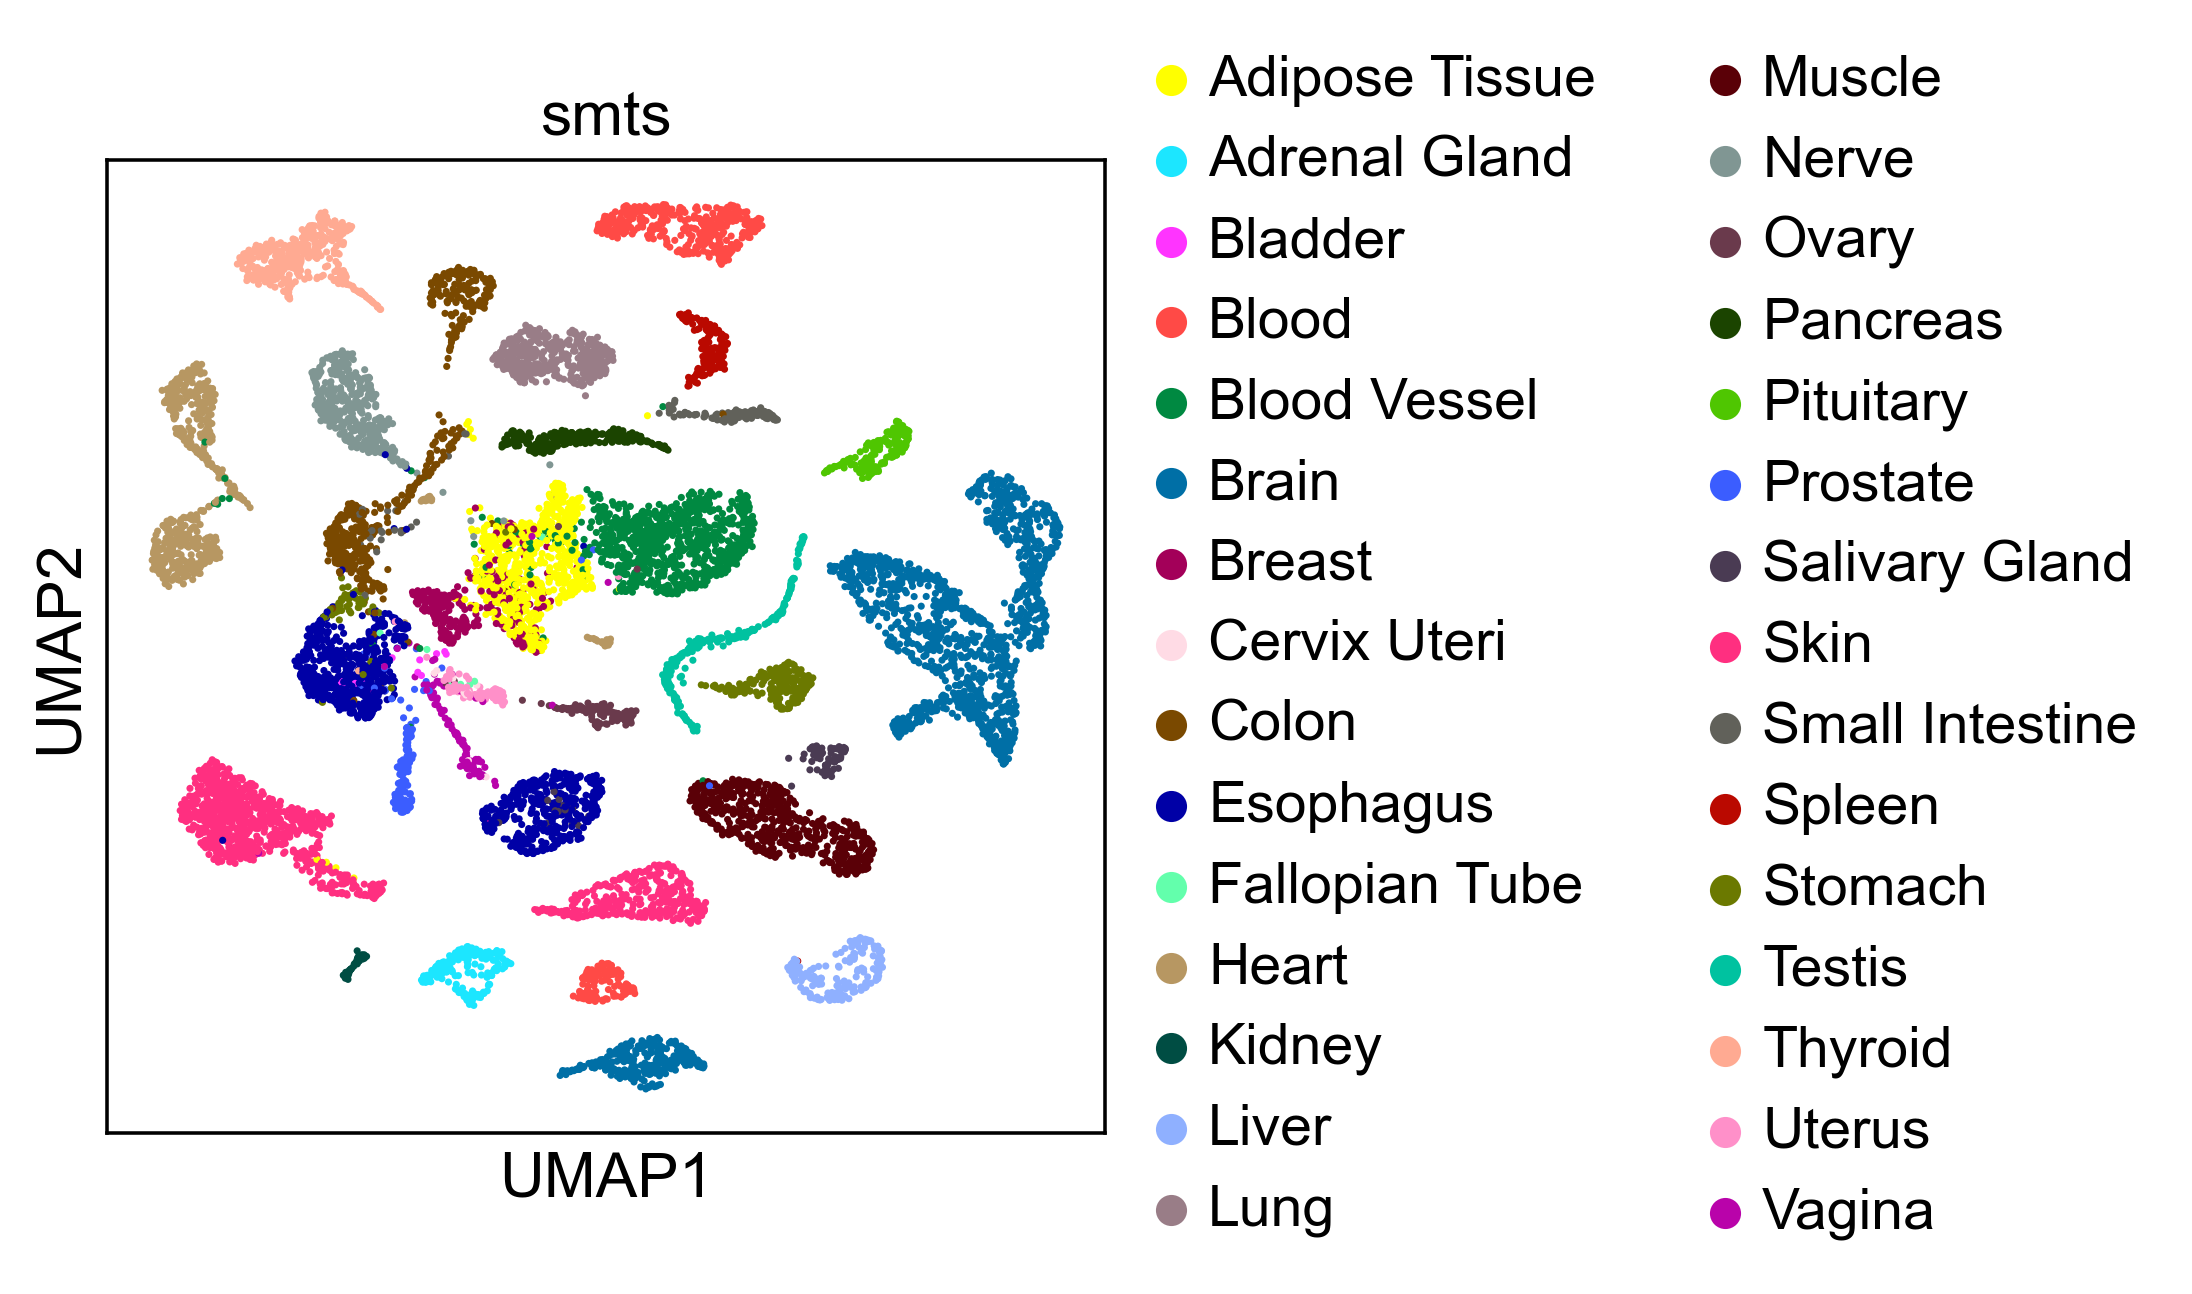

In [7]:
output = model(data)
adata.obsm["z"] = output["z"].detach().numpy()
adata.obs["predict"] = output["q_y"].detach().argmax(-1).int().numpy().astype(str)

sc.pl.umap(adata, color="smts")


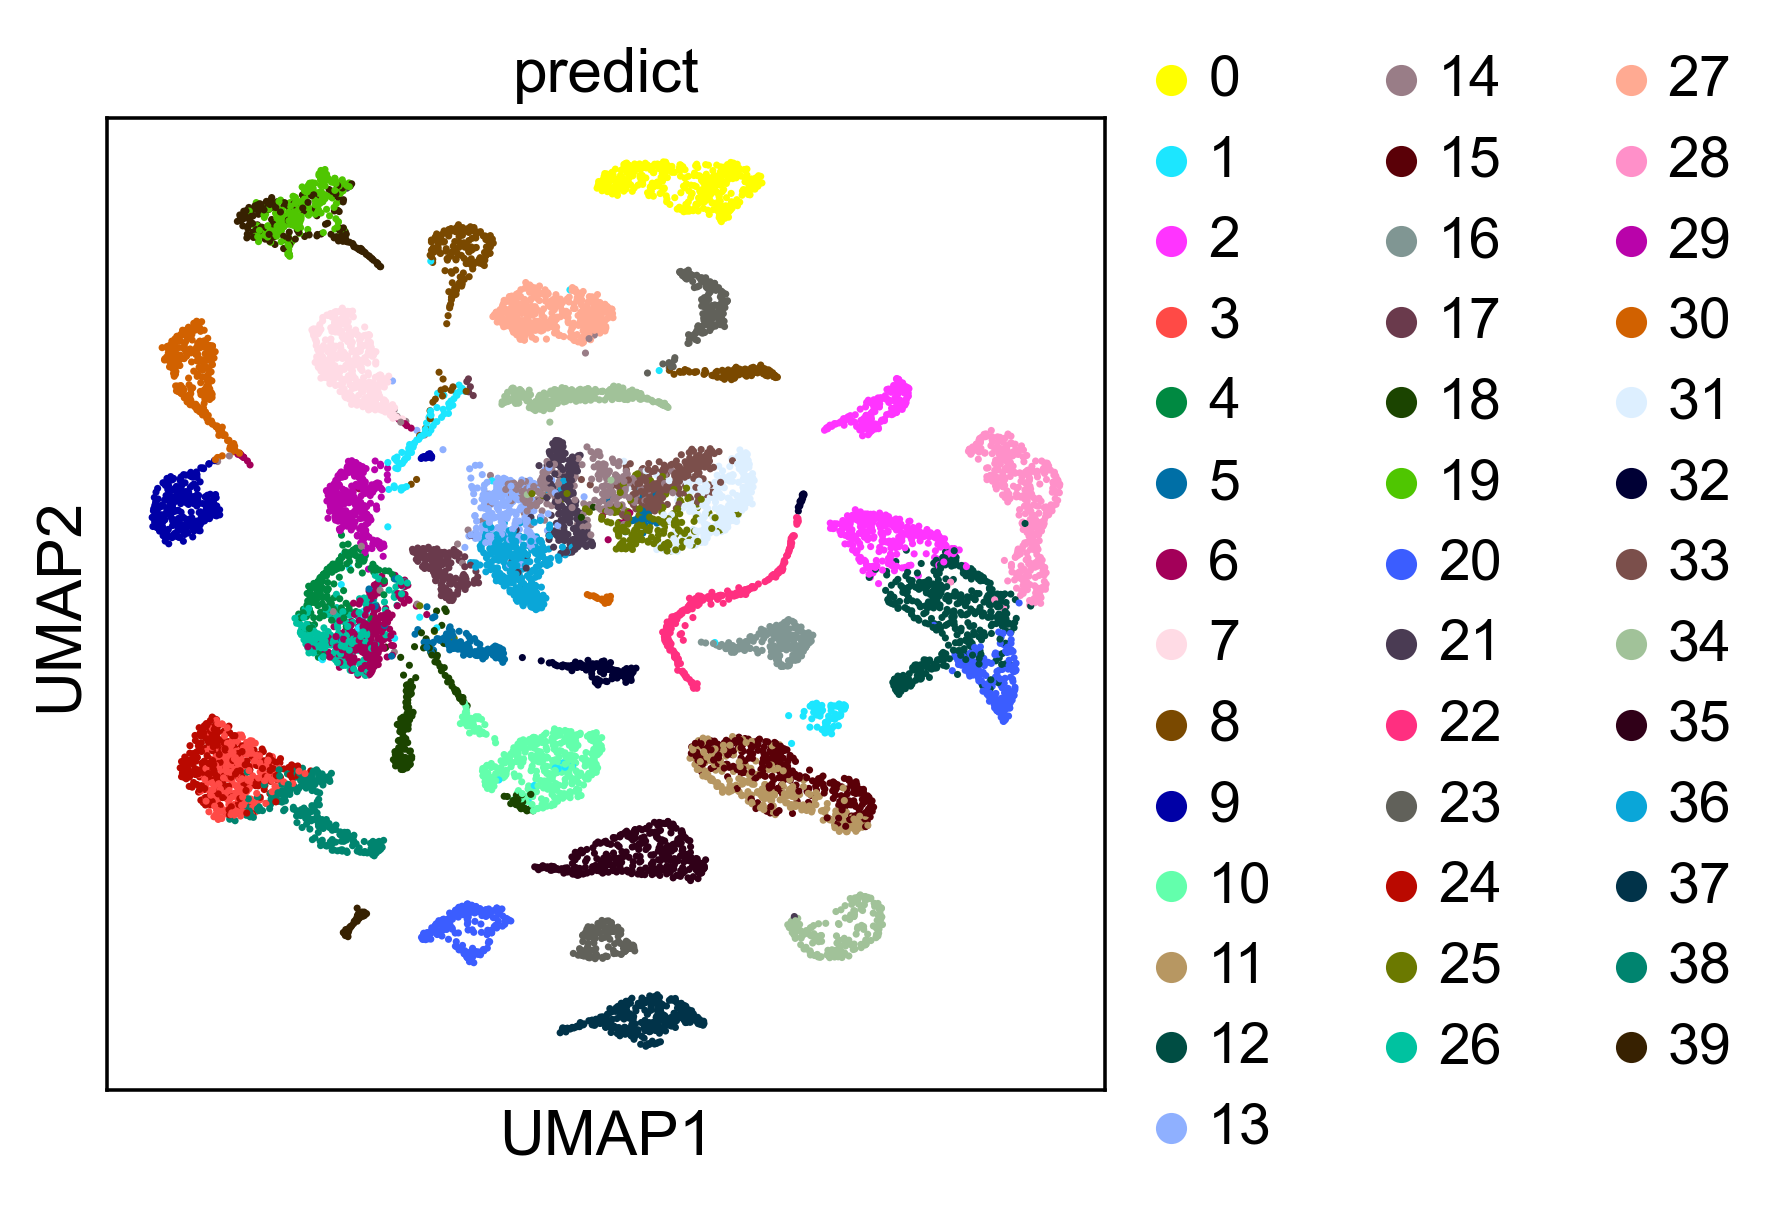

In [8]:
sc.pl.umap(adata, color="predict")


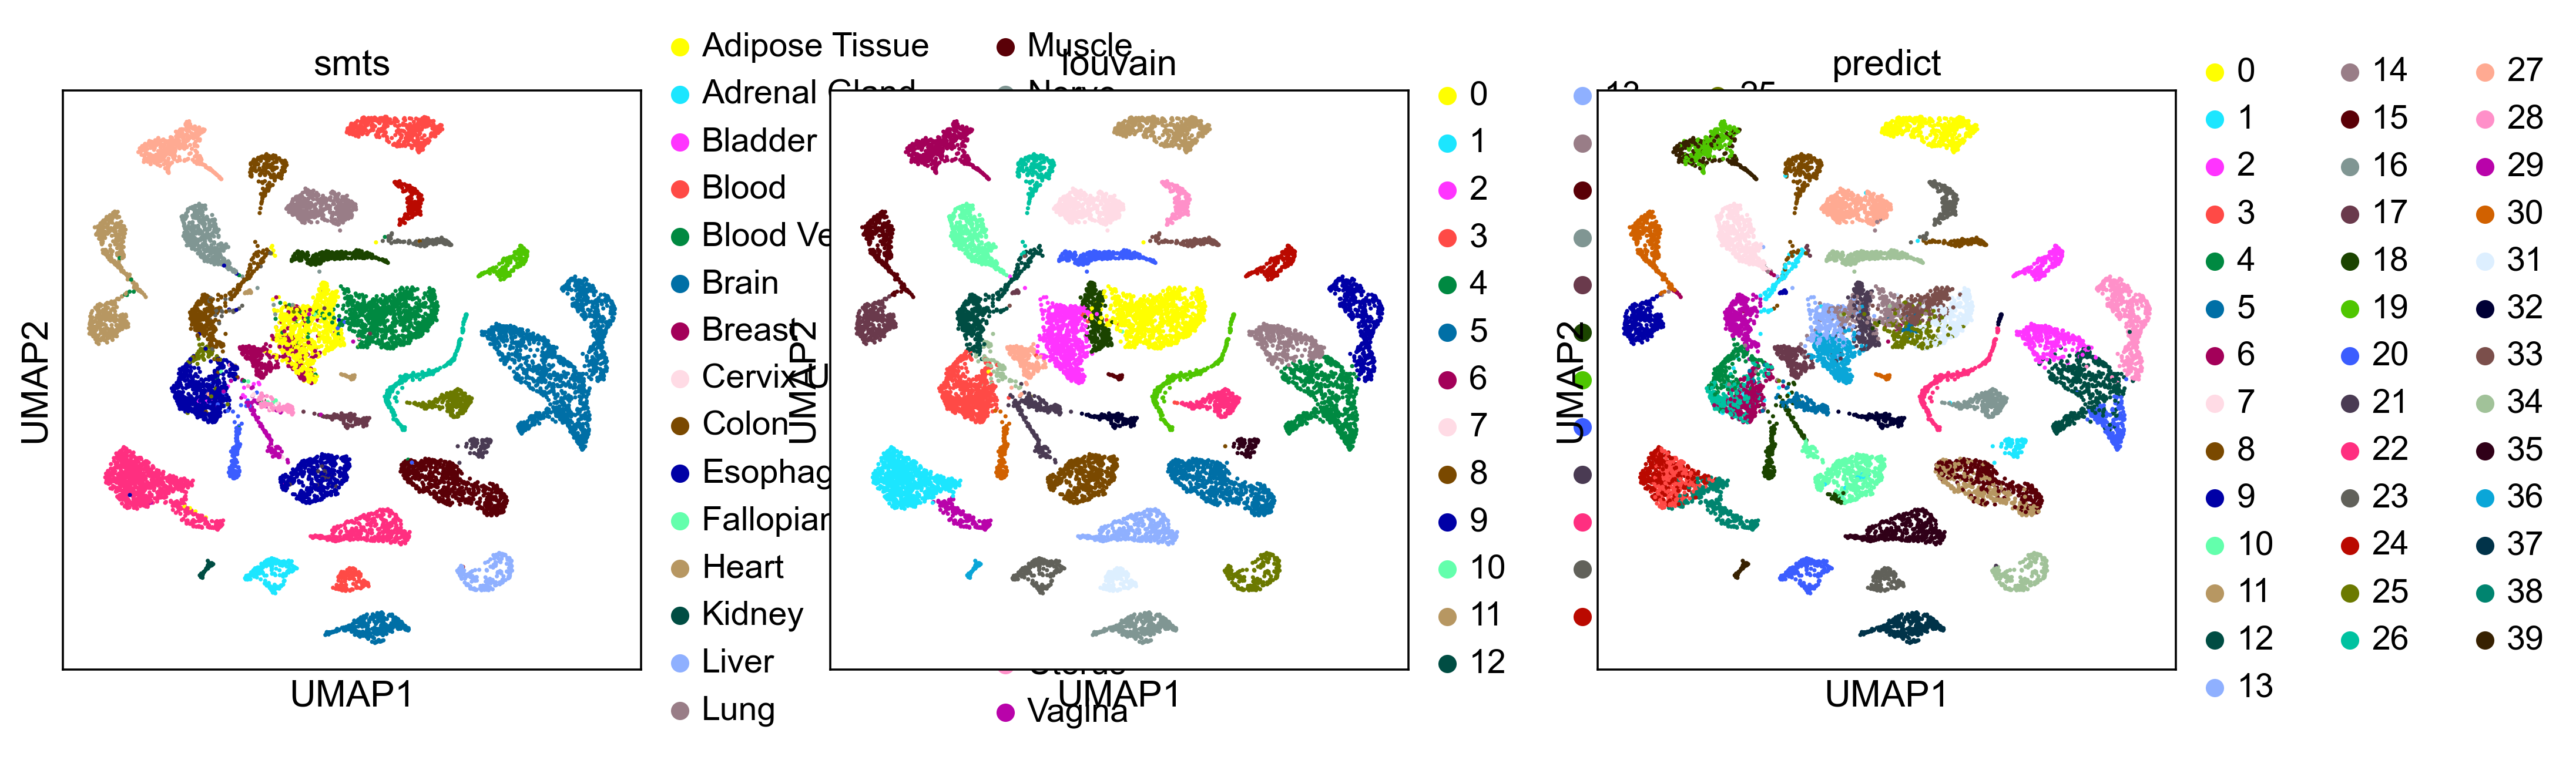

In [9]:
sc.pl.umap(adata, color=["smts", "louvain", "predict"],)

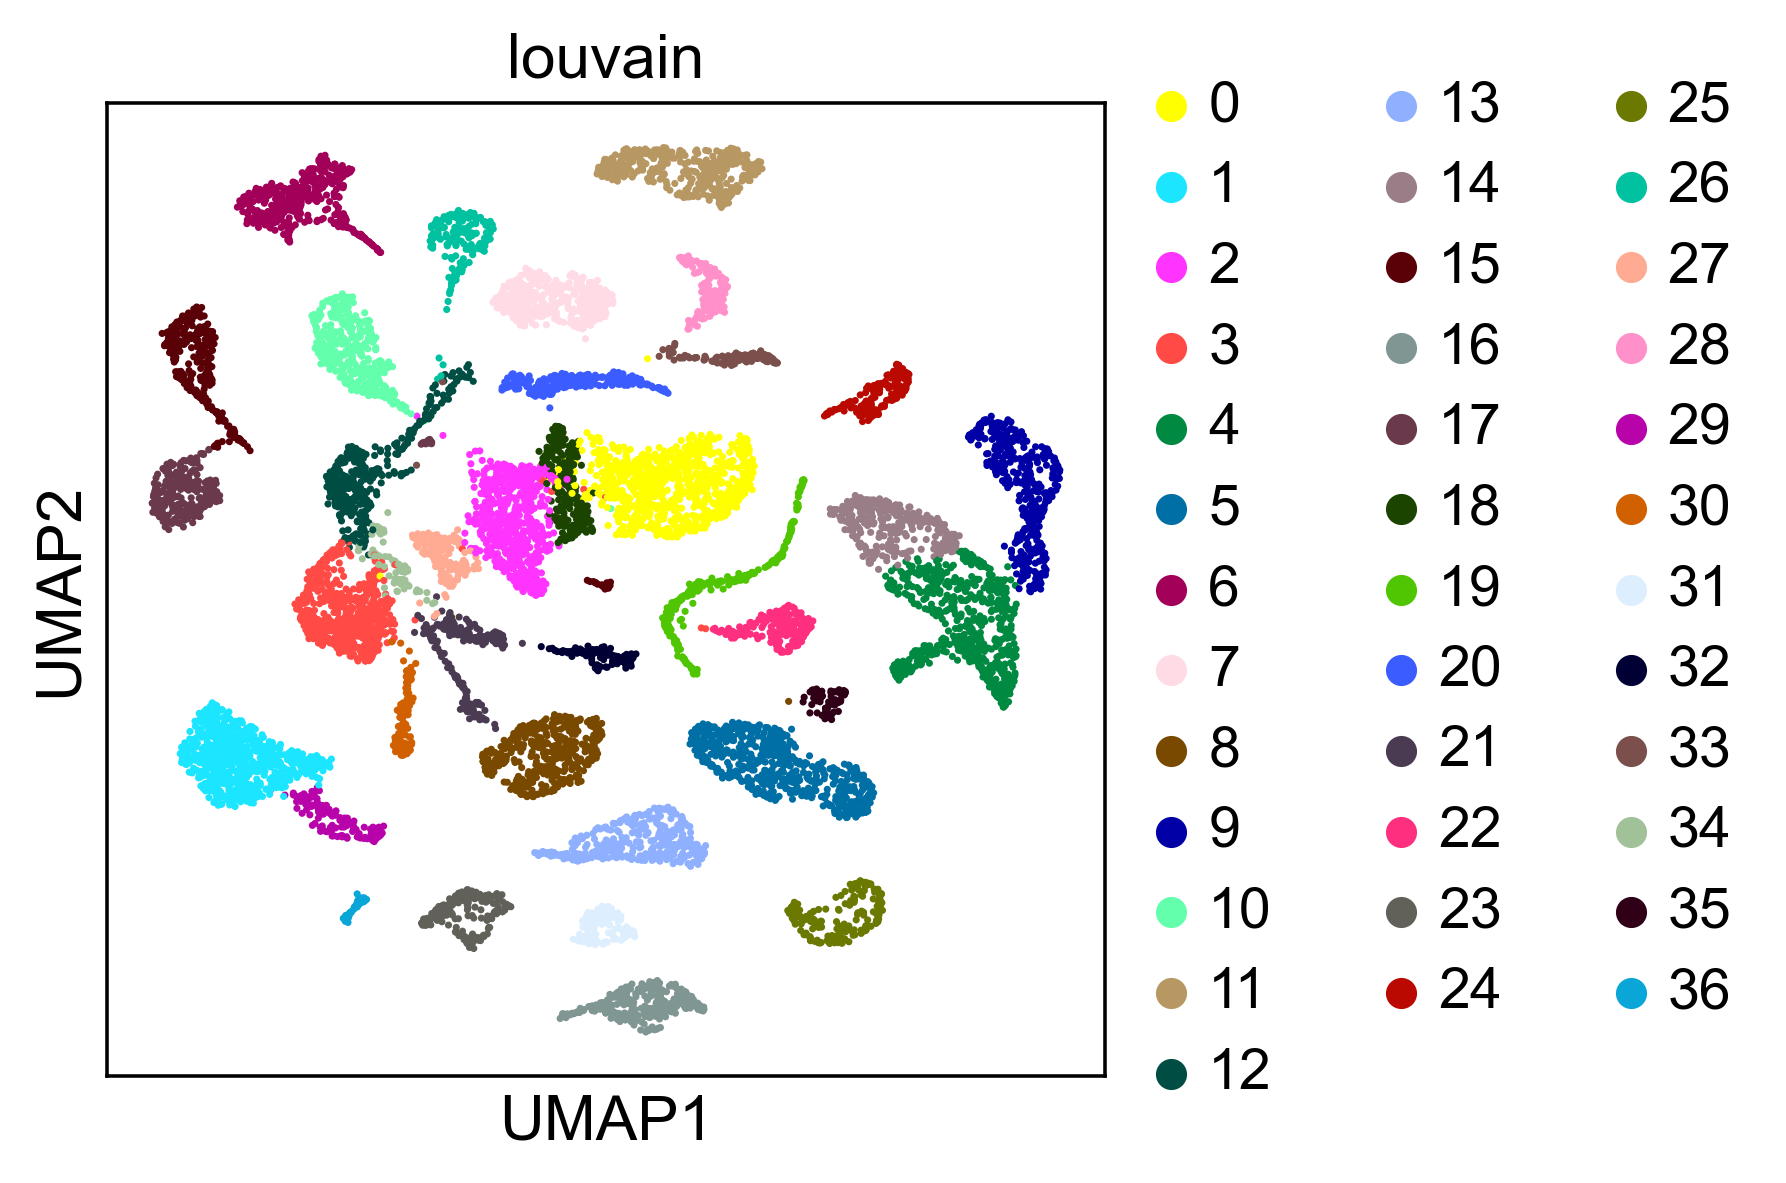

In [10]:
sc.pl.umap(adata, color="louvain")

In [12]:
model = M6.VAE_Dilo_Type601(nx=1000, nh=1024, nz=30, nw=15, nclasses=30,
        bn=True, dropout=0.2,)
M6.trainSemiSuper(model, labeled_loader, unlabeled_loader, test_loader,
        num_epochs=60, wt=0,)


labeled phase
rec: 1369.915771484375
loss_z: 8.468851089477539
loss_l: 3.3927536010742188
loss_y: -0.07179119437932968
loss_w: 1.8264068365097046
total_loss: 1414.1385498046875

unlabeled phase
rec: 1124.9039306640625
loss_z: 20.186790466308594
loss_l: 0.5276111364364624
loss_y: -0.6637884378433228
loss_w: 2.230926513671875
total_loss: 1152.5977783203125

eval phase
rec: 1089.8968505859375
loss_z: 16.815378189086914
loss_l: 1.3841960430145264
loss_y: -0.703511118888855
loss_w: 1.8092801570892334
total_loss: 1122.363525390625
ce loss: -1.3841960430145264

labeled phase
rec: 1063.577880859375
loss_z: 13.248343467712402
loss_l: 1.4445109367370605
loss_y: -0.6675463914871216
loss_w: 1.5225300788879395
total_loss: 1092.7938232421875

unlabeled phase
rec: 1016.6884765625
loss_z: 14.682819366455078
loss_l: 0.5477499961853027
loss_y: -0.7967398166656494
loss_w: 2.5779199600219727
total_loss: 1039.4267578125

eval phase
rec: 966.1441650390625
loss_z: 13.714963912963867
loss_l: 0.815400719642639

/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predict' as categorical


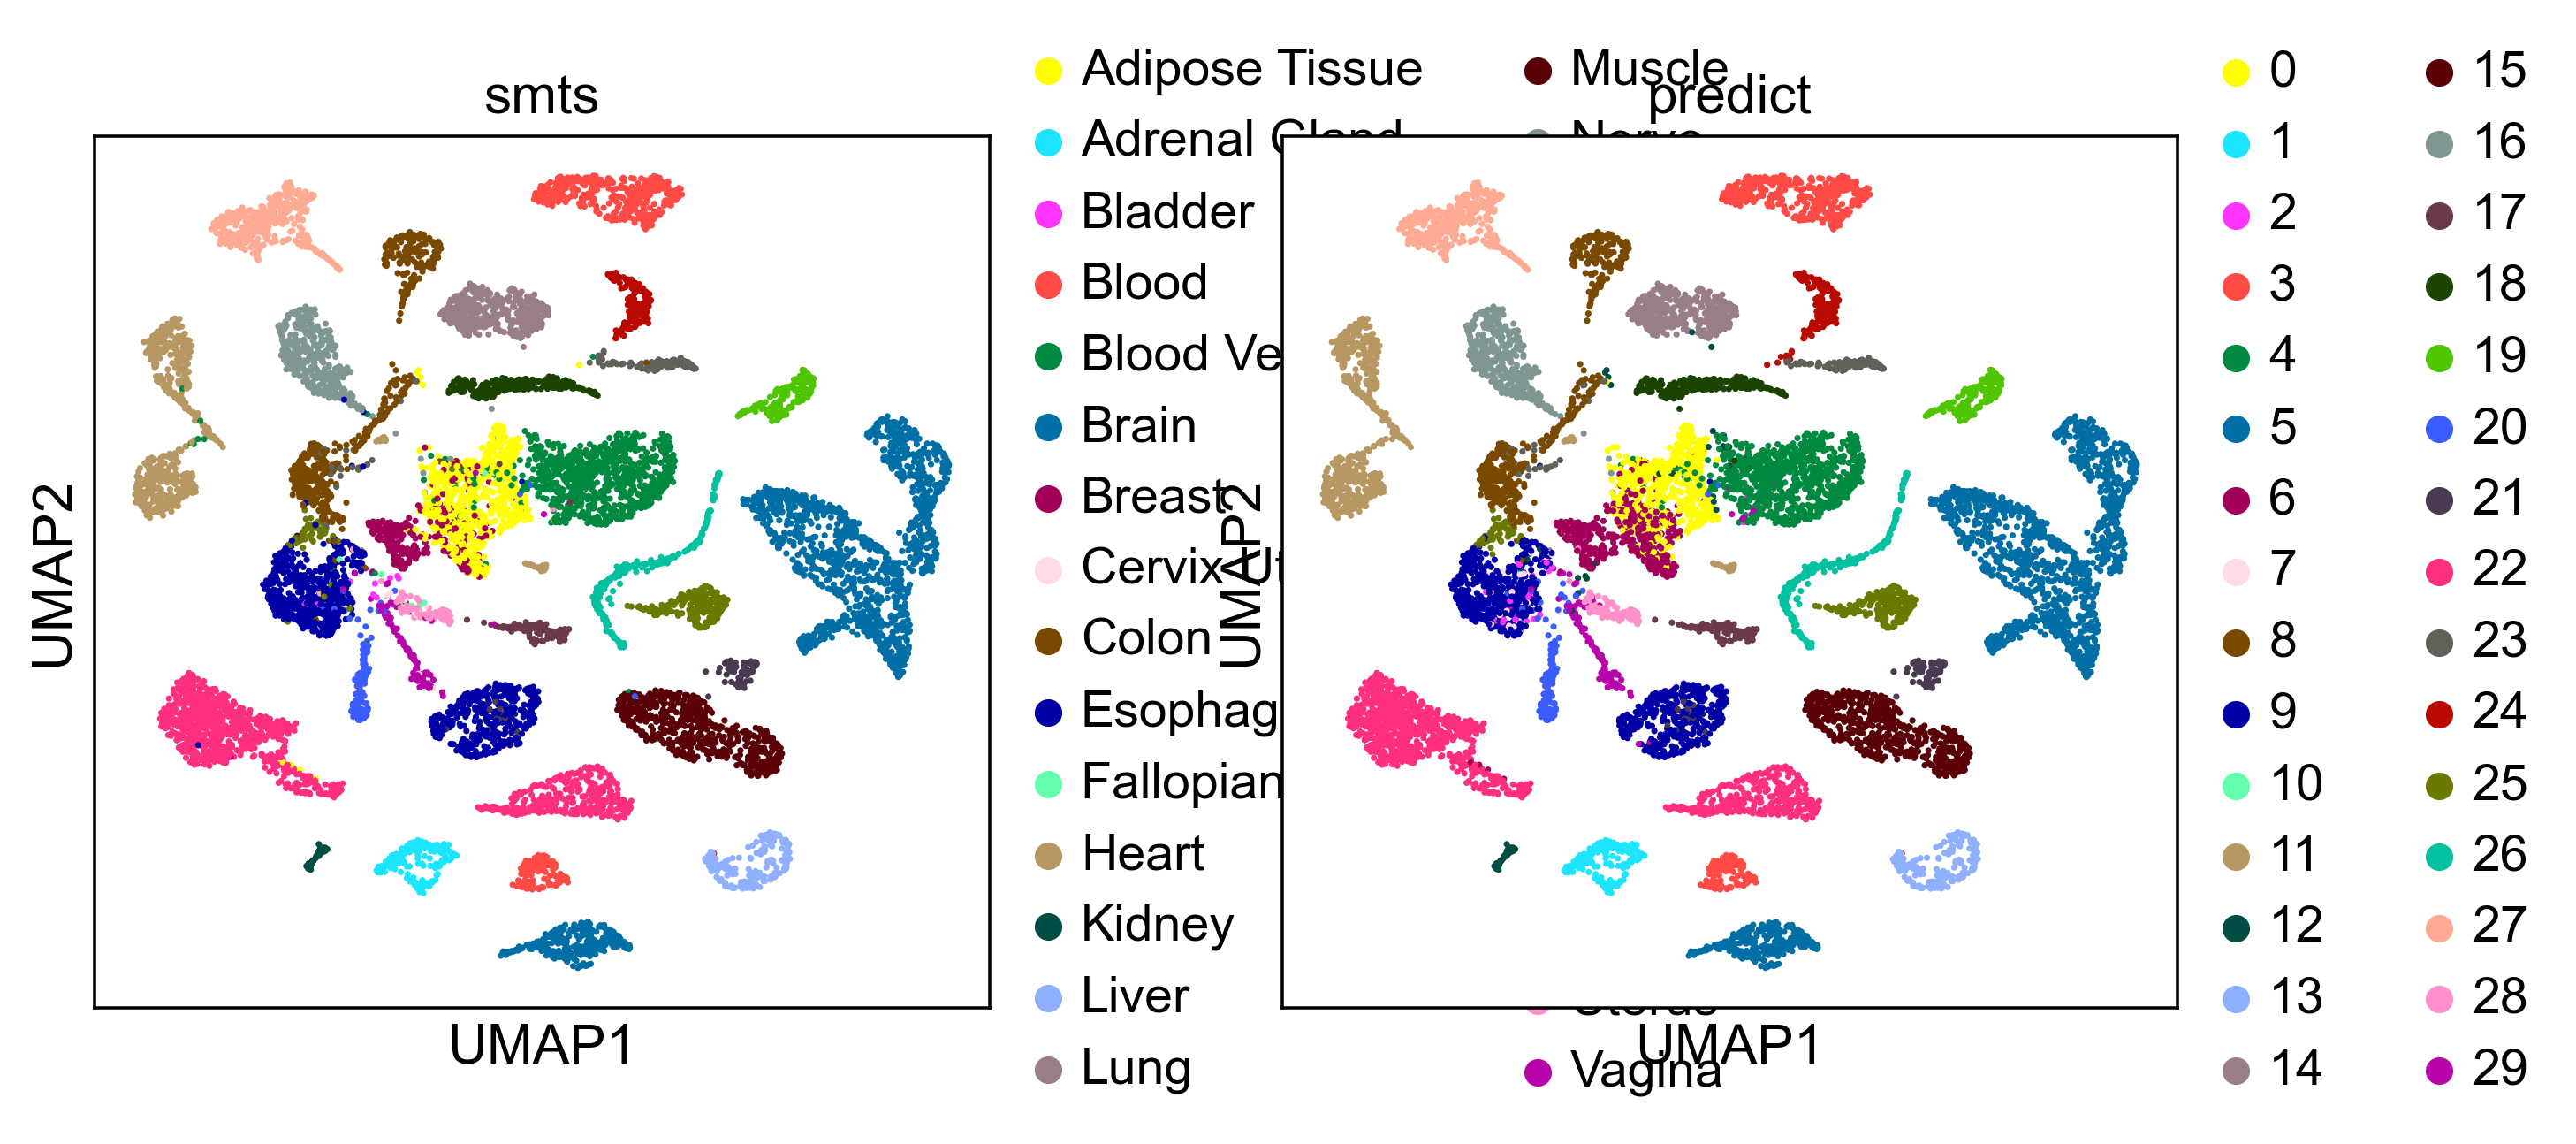

In [13]:
output = model(data)
adata.obsm["z"] = output["z"].detach().numpy()
adata.obs["predict"] = output["q_y"].detach().argmax(-1).int().numpy().astype(str)

sc.pl.umap(adata, color=["smts", "predict"])


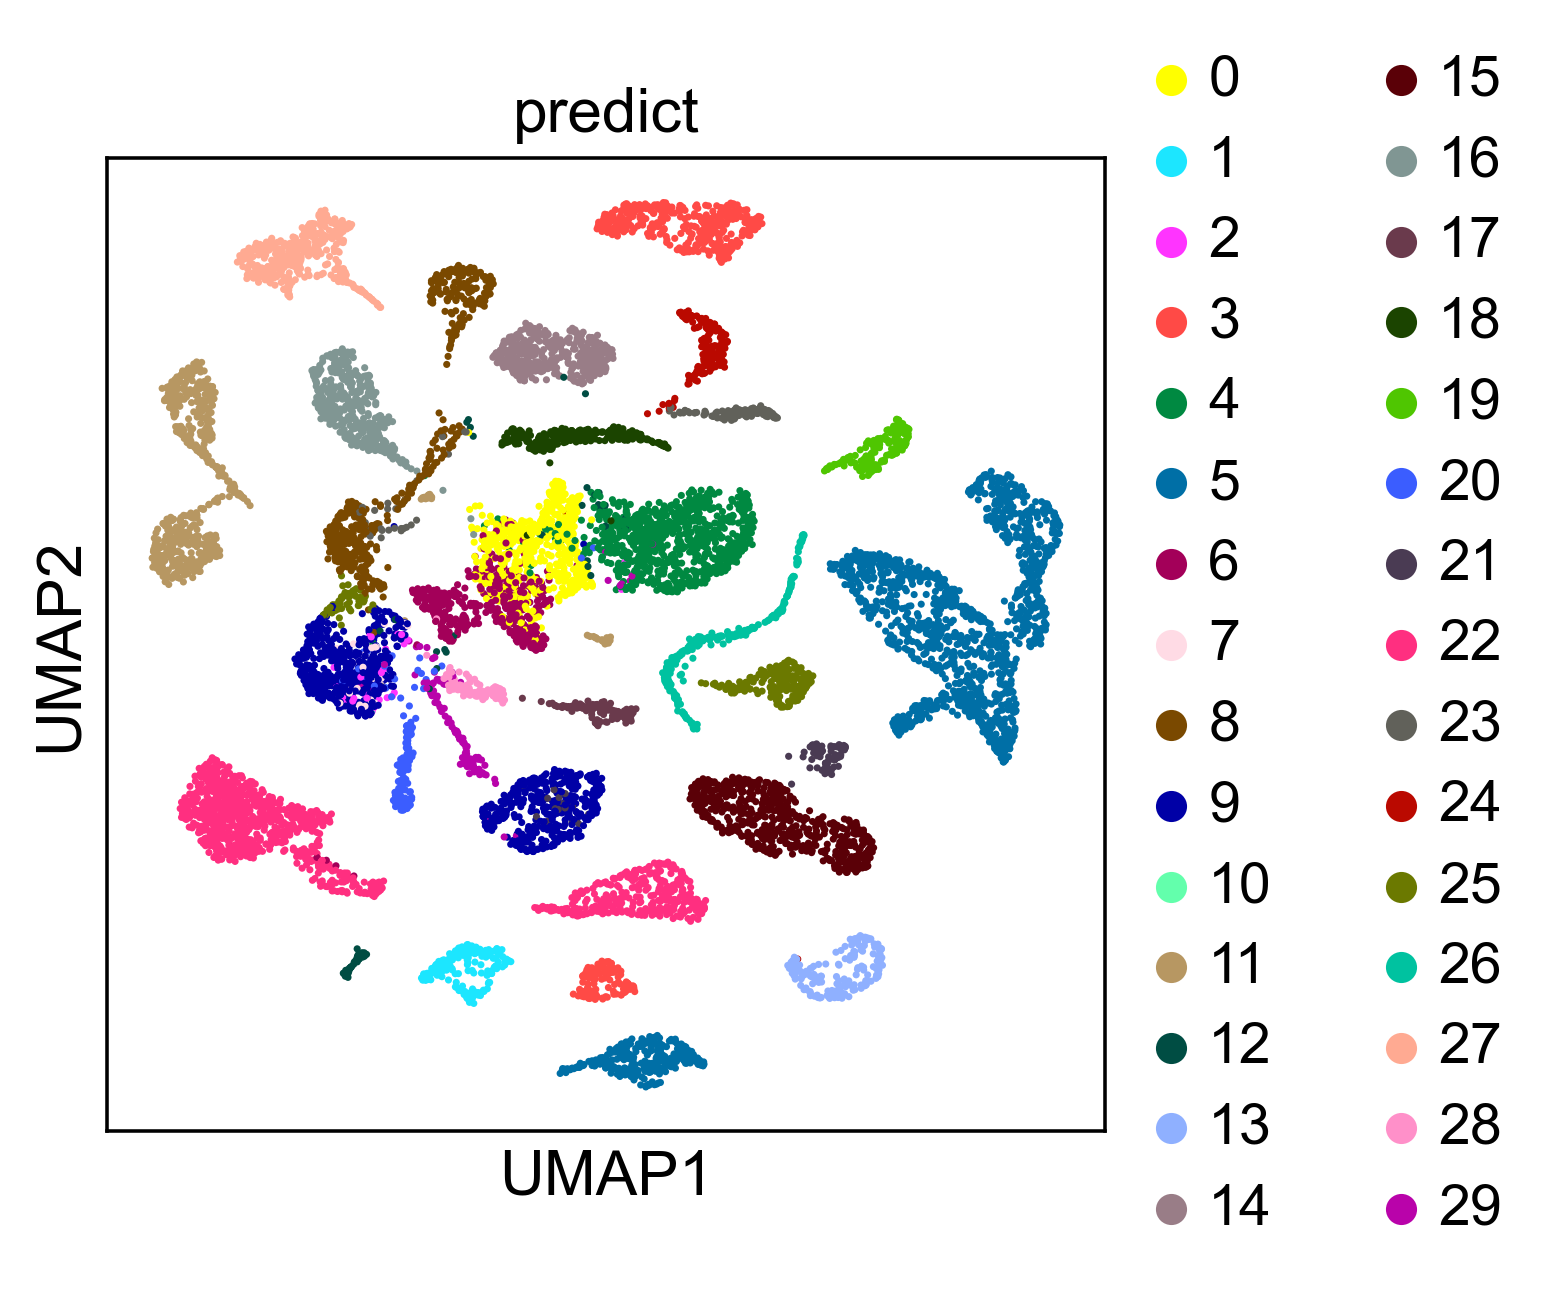

In [14]:
sc.pl.umap(adata, color=["predict"])


In [15]:
sc.pp.neighbors(adata, use_rep="z", n_neighbors=10,)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:08)


In [18]:
sc.tl.umap(adata, )

computing UMAP


/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


In [19]:
sc.tl.louvain(adata, )

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 37 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


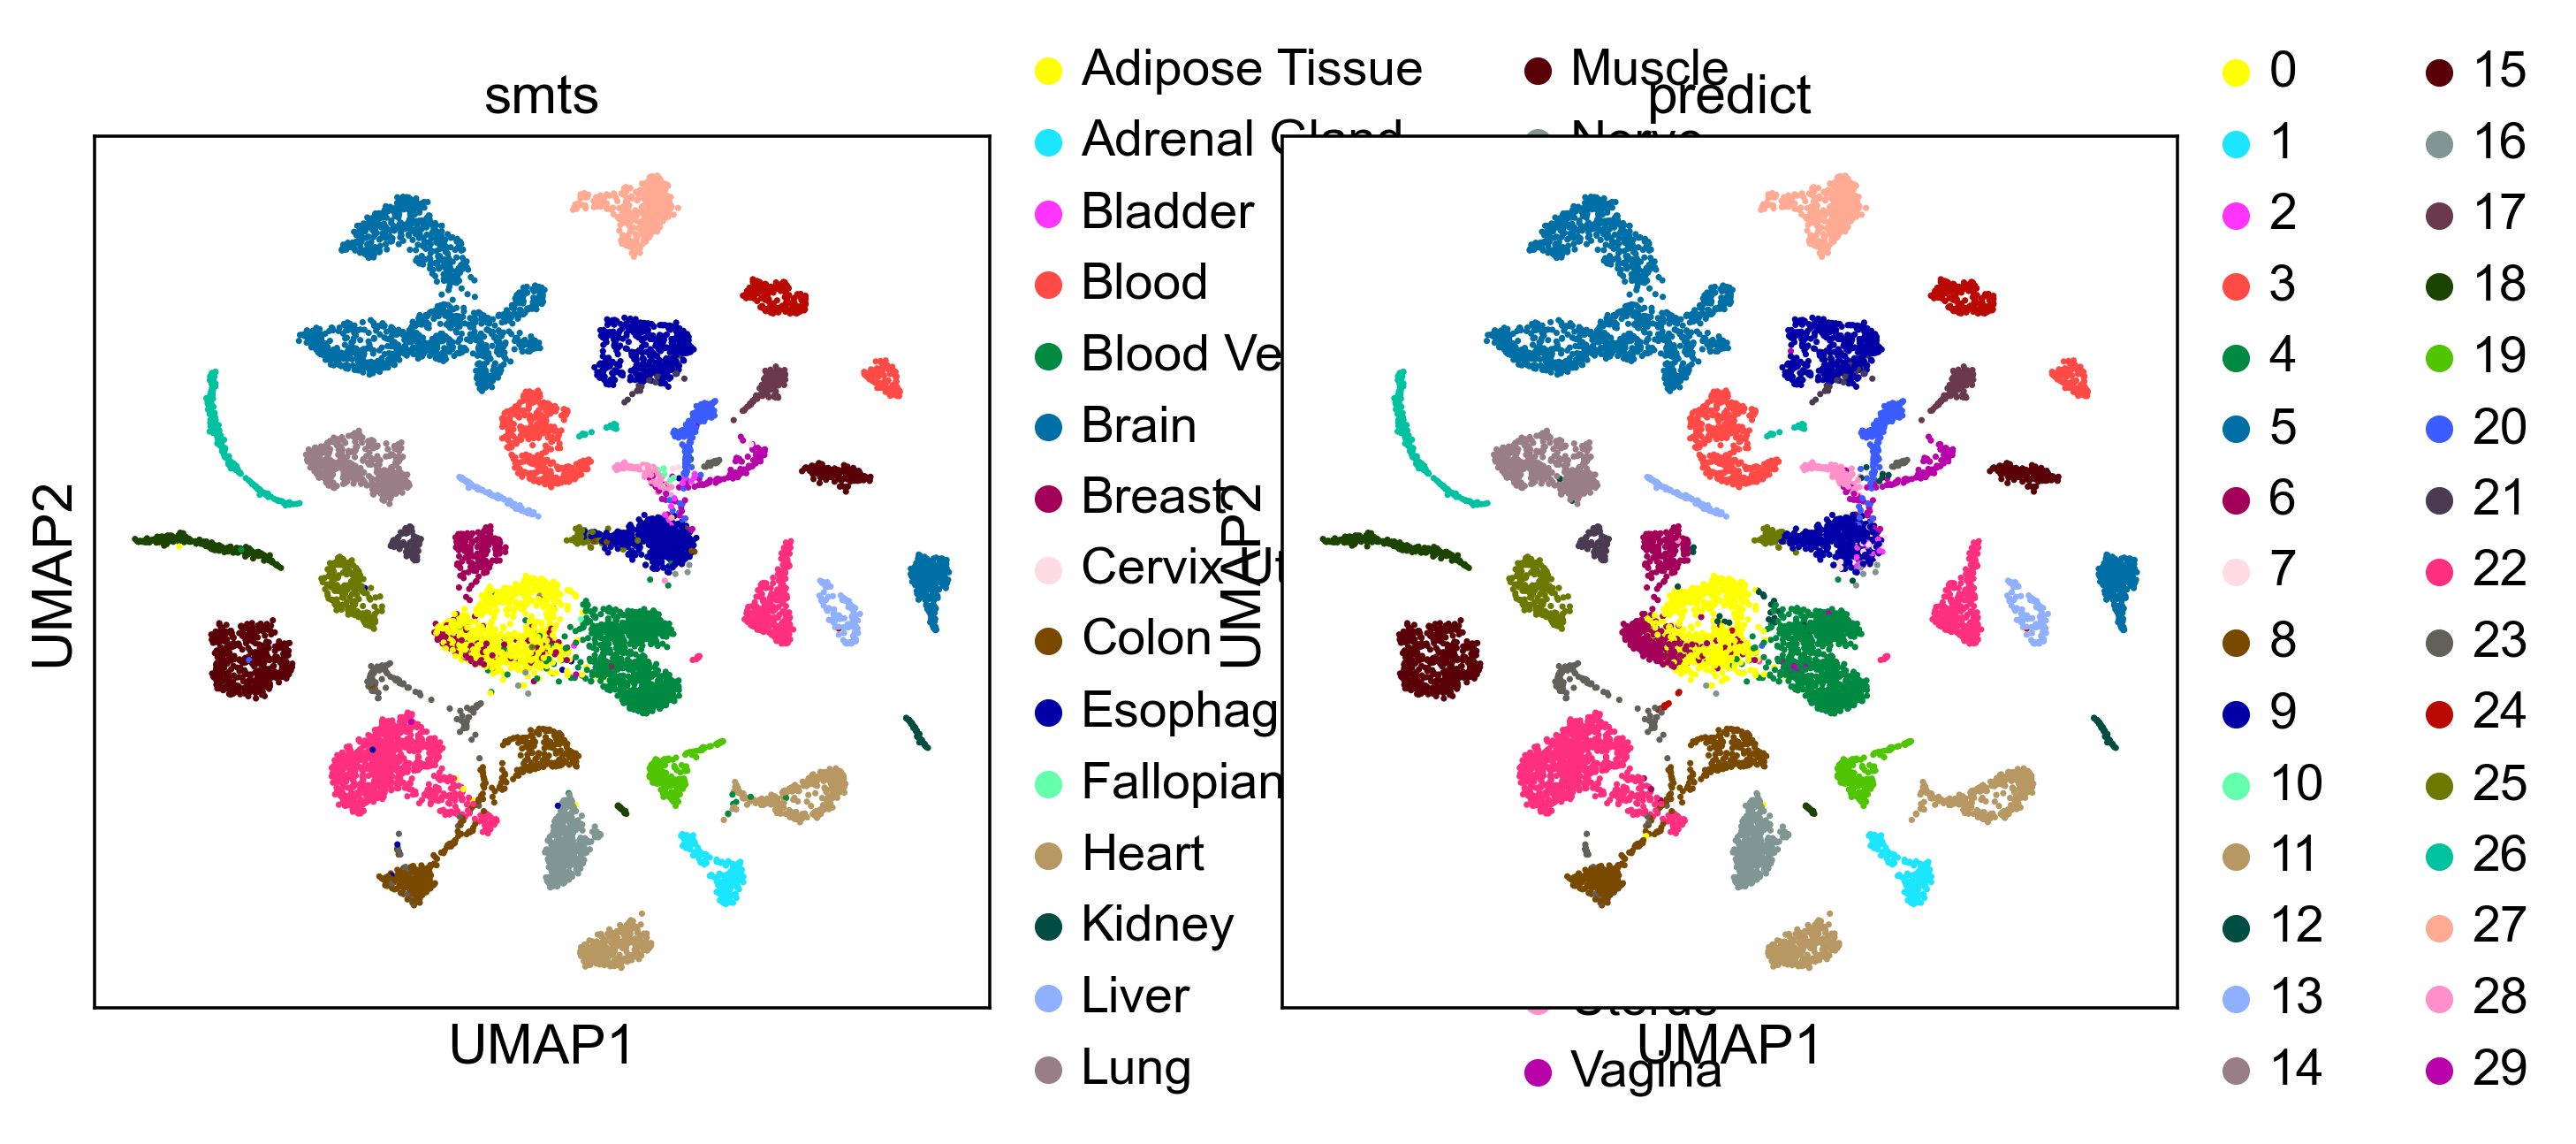

In [20]:
sc.pl.umap(adata, color=["smts", "predict"])


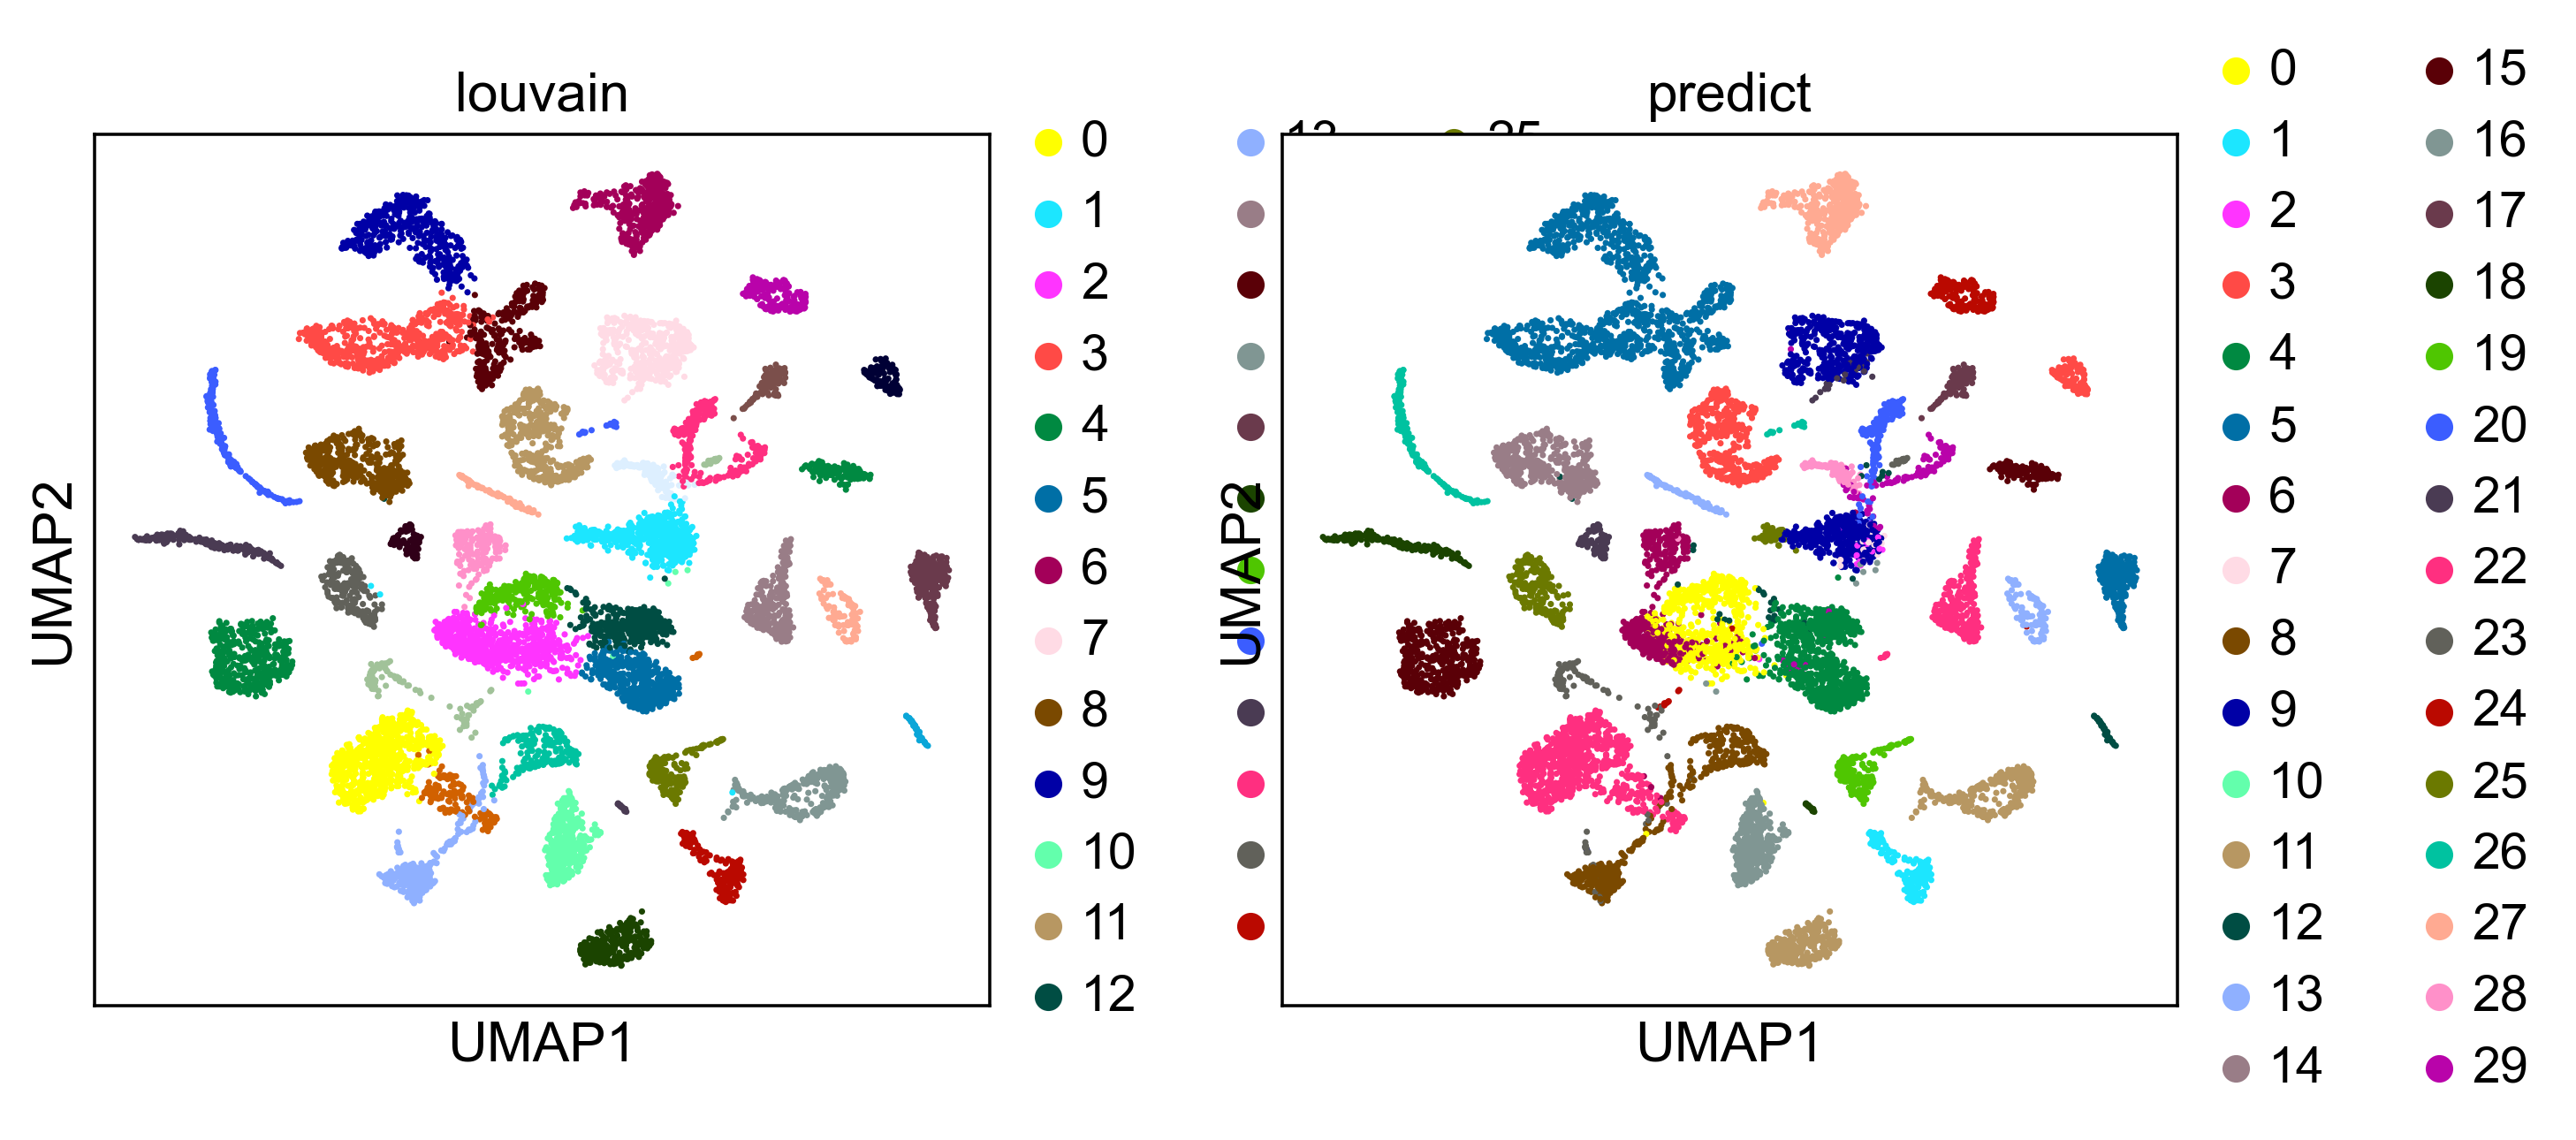

In [21]:
sc.pl.umap(adata, color=["louvain", "predict"])

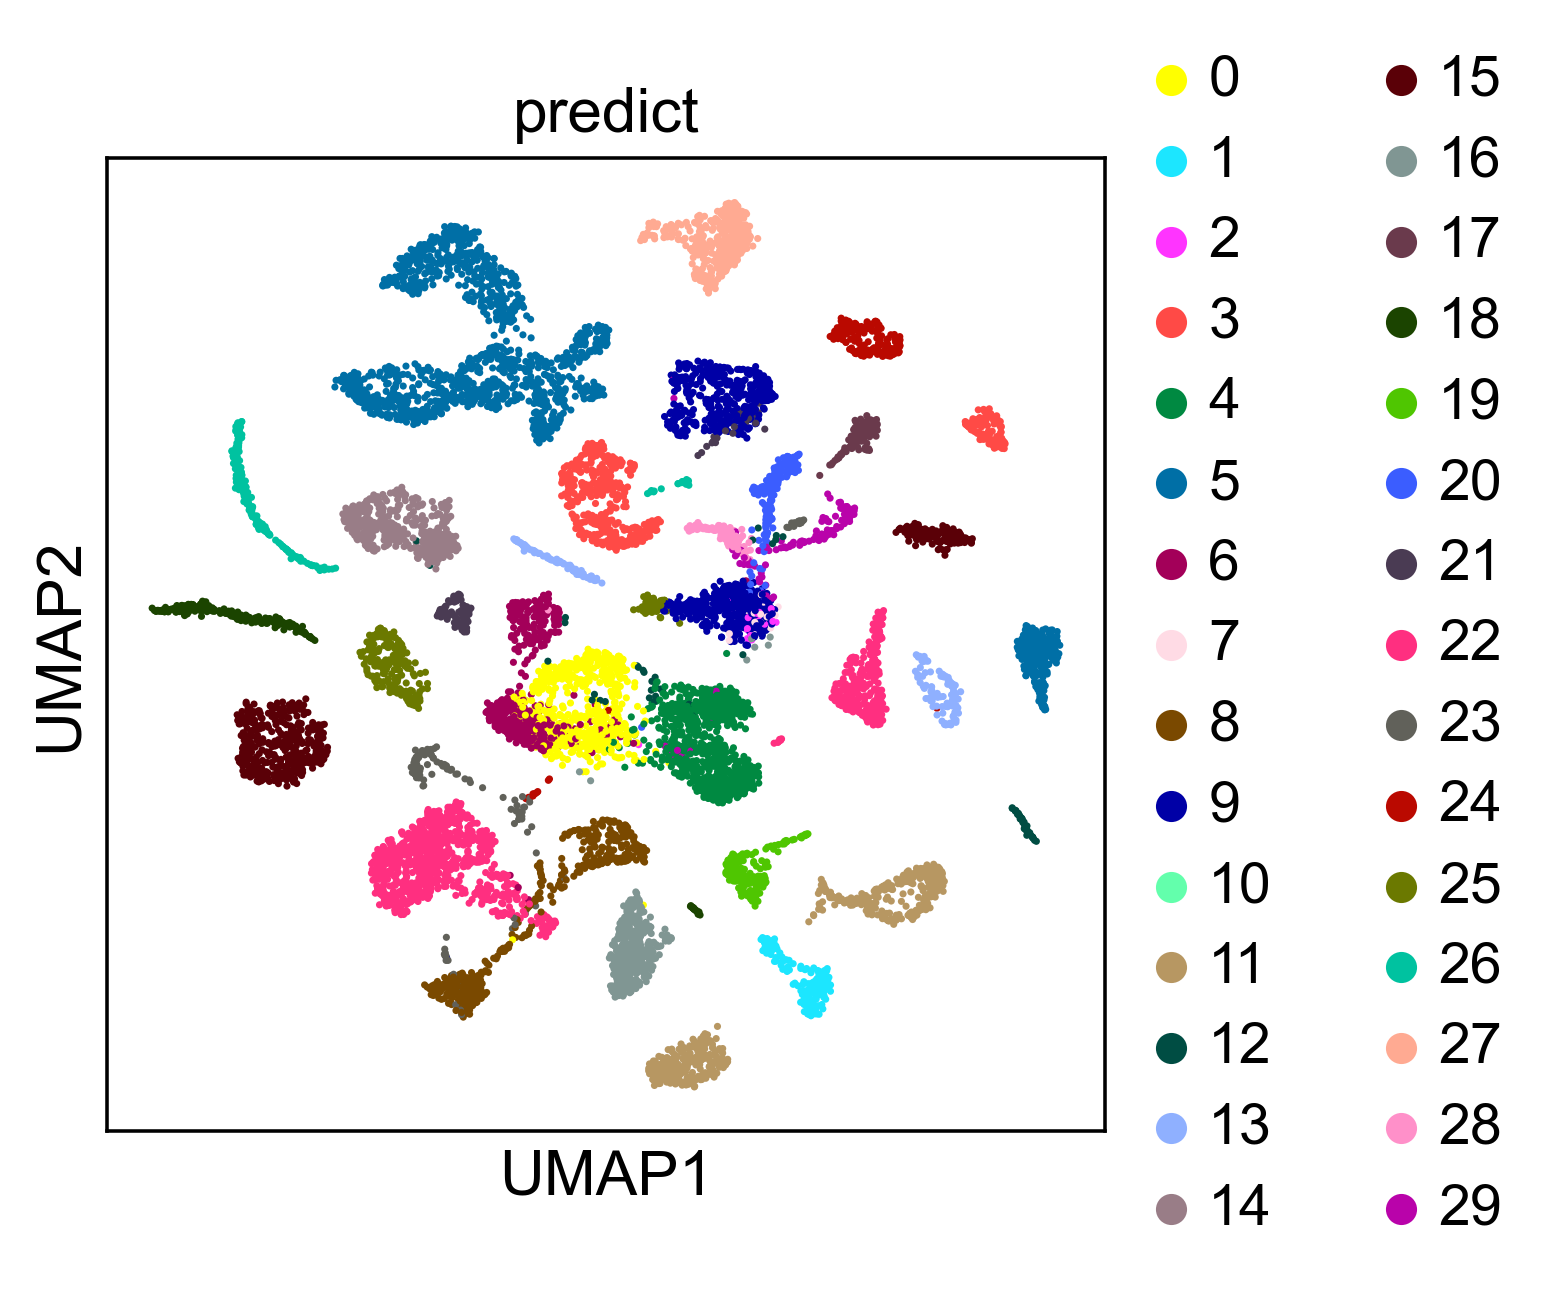

In [22]:
sc.pl.umap(adata, color=["predict"])
